# I. Entendimento do negócio

## 1. Dicionários de dados

FEATURE	| DESCRIPTION
-- | --
Date | Data das informações
Conscientização da População | Nível de conscientização sobre a dengue
Condições de Moradia Precárias | Taxa de moradias precárias na área observada
Falta de Acesso a Serviços de Saúde | Taxa de moradores sem acesso a serviços de saúde
Migração de Pessoas de Áreas Endêmicas | Taxa de migração entre áreas
Transporte de Mercadorias em Áreas Urbanas | Porcentagem de veículos de transporte de cargas
Presença de mosquito | Quantidade de mosquitos observada
Casos de dengue | Total de número de casos observados no dia
Presença de Criadouros | Porcentagem da área com presença de mosquitos
Água Parada em Terrenos Baldios | Porcentagem da área com presença de água parada
Presença de Piscinas sem Manutenção | Número de piscinas sem manutenção observadas
Presença de Recipientes sem Tampas | Número de recipientes observados no dia
Precipitação | Água proveniente do vapor de água atmosférica depositada na superfície
Umidade | Relação entre a pressão parcial da água contida no ar e a pressão de vapor da água à temperatura do ar
Temperatura | Calor da atmosfera, medido em graus Celsius (ºC)
Falta de Coleta de Lixo | Taxa de coleta de lixo realizada
Área com Acúmulo de Entulho | Porcentagem da área com entulho
Falta de Controle de Pragas | Porcentagem da área observada sem controle de pragas
Taxa de Tratamento de Esgoto | Porcentagem de esgoto não tratado na área observada
Id | 
Status | 

# II. Entendimento dos dados

## 0. IMPORTS

### 0.1. Importing libraries

In [2]:
# Data wrangling
import pandas as pd
import numpy as np
import inflection
import math
import datetime
from unidecode import unidecode

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Model Selection and Validation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Preprocessing for Pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder

# Models
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor # Baseline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Model Deployment
import pickle

# Configure sklearn to output DataFrames: Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output='pandas')

### 0.2. Helper functions

In [96]:
# DATA DESCRIPTION ---------------------------------------------------------------------------------------------------------------

def data_description(data):

    # 1. Data Dimensions
    print('*' * 20 + ' DATA DIMENSIONS ' + '*' * 20)
    print('Quantidade de linhas: {:,}'.format(data.shape[0]))
    print('Quantidade de colunas: {:,}'.format(data.shape[1]))
    print()

    # 2. Data Types
    print('*' * 20 + ' DATA TYPES ' + '*' * 25)
    print(data.dtypes)
    print()

    # 3. Check NA's
    print('*' * 20 + ' CHECK NAs ' + '*' * 26)
    print(data.isna().sum())
    print()

    # 4. Check duplicated
    print('*' * 20 + ' CHECK DUPLICATED ' + '*' * 19)
    print('Quantidade de registros duplicados: {:,}'.format(data.duplicated().sum()))

# DATA WRANGLING -----------------------------------------------------------------------------------------------

def rename_columns(cols):
    cols = list(map(lambda x: inflection.titleize(x), cols))
    cols = list(map(lambda x: x.replace(' ', ''), cols))
    cols = list(map(lambda x: unidecode(x), cols))
    cols = list(map(lambda x: inflection.underscore(x), cols))
    return cols

# Classifica por nível de proliferação
def definir_proliferacao(semana):
    # Baseado na identificação de 3 grupos muito definidos dentro da relação presenca_do_mosquito x semana_do_ano
    if 23 <= semana <= 38: return 'baixa'
    elif semana < 15 or semana > 47: return 'alta'
    else: return 'media'

# Identificar outliers
def outlier_identifier(data, row):
    high_outliers = 0  # Contador de outliers altos
    low_outliers = 0   # Contador de outliers baixos
    data['outlier'] = 'none'  # Inicializar a coluna 'outlier' com 'none'

    for week in data['semana_do_ano'].unique():
        Q1 = data.loc[data['semana_do_ano'] == week, row].quantile(0.25)
        Q3 = data.loc[data['semana_do_ano'] == week, row].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    
        # Identificar outliers baixos
        low_outliers_mask = (data[row] < lower_bound) & (data['semana_do_ano'] == week)
        low_idx_outliers = data.loc[low_outliers_mask].index
        data.loc[low_idx_outliers, 'outlier'] = 'low'
        low_outliers += len(low_idx_outliers)
        
        # Identificar outliers altos
        high_outliers_mask = (data[row] > upper_bound) & (data['semana_do_ano'] == week)
        high_idx_outliers = data.loc[high_outliers_mask].index
        data.loc[high_idx_outliers, 'outlier'] = 'high'
        high_outliers += len(high_idx_outliers)

    return data, [low_outliers, high_outliers]

# Identifica outliers em todas as colunas
#def identificar_outliers(data_raw, colunas):
#    data = data_raw.copy()
#    outliers = {}
#    data['outlier'] = 'Não'
#
#    for col in colunas:
#        Q1 = data[col].quantile(0.25)
#        Q3 = data[col].quantile(0.75)
#        IQR = Q3 - Q1
#        lower_bound = Q1 - 1.5 * IQR
#        upper_bound = Q3 + 1.5 * IQR
        
#        # Identificar outliers
#        outliers_mask = (data[col] < lower_bound) | (data[col] > upper_bound)
#        data.loc[outliers_mask, 'outlier'] = 'Sim'
#        outliers[col] = data[outliers_mask].shape[0]
#    
#    return data, outliers

# Calcula a média por período (semana)
def preencher_nan_por_semana(data, col):
    for semana in data['semana_do_ano'].unique():
        mediana_da_semana = data.loc[data['semana_do_ano'] == semana, col].median()
        faltantes = data.loc[data[col].isna(), :].index
        data[col] = data[col].apply(lambda x: mediana_da_semana if math.isnan(x) else x)

# DATA CLEANING ---------------------------------------------------------------------------------------------------------------

def data_cleaning(data_raw, colunas_float, colunas_int):

    # Faz uma cópia do dataframe
    data = data_raw.copy()

    # 3. Transformar 'indisponivel' em NA
    for col in colunas_float:
        if 'indisponivel' in data[col].values:
            data[col] = data[col].replace('indisponivel', np.nan)
    
    # 4. Substituir ',' por '.' e Converter colunas_float de object para float
    for col in colunas_float:
        if data[col].astype(str).str.contains(',').any():
            data[col] = data[col].str.replace(',', '.', regex=False).astype(float)
   
    # 5. Converter date para o tipo datetime
    data['date'] = pd.to_datetime(data['date'])

    # 6. Converter colunas_int de object para numerico
    for col in (colunas_int + colunas_float):
        data[col] = pd.to_numeric(data[col], errors='coerce')  # coerce errors to NaN

    # 7. Incluir colunas de data
    data['mes'] = data['date'].dt.month
    data['semana_do_ano'] = data['date'].dt.isocalendar().week

    # 8. Selecionar os índices dos registros que contêm NAN's
    idx_nans = data[data.isna().any(axis=1)].index

    # 9. Preencher NA's colunas_int
    for col in colunas_int:
        mediana = data[col].median()
        data[col] = data[col].fillna(mediana)

    # 10. Preencher NA's colunas_float por semana do ano
    for col in colunas_float:
        preencher_nan_por_semana(data, col)

    # 9 e 10 Preencher NA's
    #data.fillna(0, inplace=True)

    # 11. Converter colunas_int de object para int
    for col in colunas_int:
        data[col] = data[col].astype(int)    

    return data, idx_nans

# FEATURE ENGINEERING ---------------------------------------------------------------------------------------------------------------

def feature_engineering(data_raw):
    # Faz uma cópia do dataframe
    data = data_raw.copy()

    # 1. Classifica por nível de proliferação
    data['proliferacao'] = data['semana_do_ano'].apply(lambda x: definir_proliferacao(x))

    # 2. Incluir coluna que identifica outliers
    #data, _ = outlier_identifier(data, 'casos_de_dengue')

    return data

# DATA PREPARATION -------------------------------------------------------------------------------------------

# Funções nomeadas globais para as transformações seno e cosseno
def sin_transform(x, period):
    return np.sin(x / period * 2 * np.pi)

def cos_transform(x, period):
    return np.cos(x / period * 2 * np.pi)

# Funções de transformação utilizando FunctionTransformer
def sin_transformer(period):
    return FunctionTransformer(func=sin_transform, kw_args={'period': period})

def cos_transformer(period):
    return FunctionTransformer(func=cos_transform, kw_args={'period': period})

# MODEL VALIDATION --------------------------------------------------------------------------------------------------------------------

# Medir a performance do modelo
def get_metrics(y_true, y_pred):
    dict_metrics  = {
        'R2': float(metrics.r2_score(y_true, y_pred)),
        'MAE': float(metrics.mean_absolute_error(y_true, y_pred)),
        'MAPE': float(metrics.mean_absolute_percentage_error(y_true, y_pred)),
        'RMSE': float(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    }
    return dict_metrics

### 0.3. Loading data

In [4]:
path = '../data/'

tb_fato                 = pd.read_csv(path + 'tb_fato.csv', low_memory=False, decimal='.')
tb_casos_dengue         = pd.read_csv(path + 'tb_casos_dengue.csv', low_memory=False, decimal='.')
tb_agua_parada          = pd.read_csv(path + 'tb_agua_parada.csv', low_memory=False, decimal='.')
tb_condicoes_climaticas = pd.read_csv(path + 'tb_condicoes_climaticas.csv', low_memory=False, decimal='.')
tb_falta_higiene        = pd.read_csv(path + 'tb_falta_higiene.csv', low_memory=False, decimal='.')
tb_conscientizacao      = pd.read_csv(path + 'tb_conscientizacao.csv', low_memory=False, decimal='.')

#### 0.3.1 Unir tabelas

In [5]:
# Unir tabelas
df_raw = pd.merge(tb_fato, tb_casos_dengue, how='left', on='Date', suffixes=('_fato', '_casos'))
df_raw = df_raw.merge(tb_agua_parada, how='left', on='Date', suffixes=('', '_agua'))
df_raw = df_raw.merge(tb_condicoes_climaticas, how='left', on='Date', suffixes=('', '_cli'))
df_raw = df_raw.merge(tb_falta_higiene, how='left', on='Date', suffixes=('', '_hig'))
df_raw = df_raw.merge(tb_conscientizacao, how='left', left_on='conscientização da população', right_on='id', suffixes=('', '_consc'))

#### 0.3.2. Separar o arquivo de teste

In [6]:
# Separar o arquivo de teste (os últimos 1500 dias, onde os casos de dengue estão faltando)
df_teste_raw = df_raw.loc[df_raw['Casos de dengue'].isna(), :].reset_index(drop=True)

# Remover os dados da amostra
casos_faltantes = df_raw.loc[df_raw['Casos de dengue'].isna(), :].index
df_raw = df_raw.drop(casos_faltantes, axis=0).reset_index(drop=True)

## 1. DATA DESCRIPTION

Impressão da descrição dos dados antes da limpeza (Data Cleaning)

In [7]:
# Descrição dos dados sem modificação
print('*' *9 + ' Descrição dos dados de treino | Antes ' + '*' *9)
data_description(df_raw)

********* Descrição dos dados de treino | Antes *********
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 24,028
Quantidade de colunas: 22

******************** DATA TYPES *************************
Date                                           object
conscientização da população                    int64
condições de moradia precárias                 object
falta de acesso a serviços de saúde            object
migração de pessoas de áreas endêmicas         object
transporte de mercadorias em áreas urbanas     object
outros                                         object
presença do mosquito                           object
Casos de dengue                               float64
Presença de Criadouros                         object
Água Parada em Terrenos Baldios                object
Presença de Piscinas sem Manutenção            object
Presença de Recipientes sem Tampas             object
Precipitação                                   object
Umidade       

In [8]:
# Descrição dos dados de teste sem modificação
print('*' *10 + ' Descrição dos dados de teste | Antes ' + '*' *9)
data_description(df_teste_raw)

********** Descrição dos dados de teste | Antes *********
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 3,000
Quantidade de colunas: 22

******************** DATA TYPES *************************
Date                                           object
conscientização da população                    int64
condições de moradia precárias                 object
falta de acesso a serviços de saúde            object
migração de pessoas de áreas endêmicas         object
transporte de mercadorias em áreas urbanas     object
outros                                         object
presença do mosquito                           object
Casos de dengue                               float64
Presença de Criadouros                         object
Água Parada em Terrenos Baldios                object
Presença de Piscinas sem Manutenção            object
Presença de Recipientes sem Tampas             object
Precipitação                                   object
Umidade        

## 2. DATA CLEANING

Vamos gerar dois dataframes limpos aqui, sendo:
1. Dataframe sem os NA's para que possamos avaliar a melhor forma de preenchimento ou a possibilidade de exclusão dos mesmos;
2. Dataframe completo e com os NA's preenchidos de acordo com a análise realizada.

Colunas selecionadas:
- Colunas selecionadas para análise = 'date', 'status', 'precipitacao', 'umidade', 'temperatura', 'presenca_do_mosquito', 'casos_de_dengue'
- Numéricas: 'casos_de_dengue', 'presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura' 
- Categóricas: 'status' -
- Data: 'date'

In [9]:
colunas_int = ['casos_de_dengue', 
               'presenca_do_mosquito', 
               'conscientizacao_da_populacao',
               'presenca_de_recipientes_sem_tampas',
               'id']

colunas_float = ['precipitacao', 
                 'umidade',
                 'temperatura', 
                 'condicoes_de_moradia_precarias',
                 'falta_de_acesso_a_servicos_de_saude',
                 'migracao_de_pessoas_de_areas_endemicas',
                 'transporte_de_mercadorias_em_areas_urbanas', 
                 'outros',
                 'presenca_de_criadouros',
                 'agua_parada_em_terrenos_baldios',
                 'presenca_de_piscinas_sem_manutencao',
                 'falta_de_coleta_de_lixo',
                 'areas_com_acumulo_de_entulhos', 
                 'falta_de_controle_de_pragas',
                 'taxa_de_tratamento_de_esgoto']

categorical_rows = ['status']


In [89]:
# Fazer uma cópia do dataframe original
df = df_raw.copy()

# 0. Renomear colunas
df.columns = rename_columns(df.columns)

# 0. Remover duplicatas
df = df.drop_duplicates().reset_index(drop=True)

# Selecionar colunas
colunas_int = ['presenca_do_mosquito']

colunas_float = ['precipitacao',
                 'umidade',
                 'temperatura']

colunas_numericas = colunas_float + colunas_int

selected_rows = ['casos_de_dengue', 'date'] + colunas_numericas

In [15]:
# Limpar dataframe completo 
df_cleaned, idx_nans = data_cleaning(df[selected_rows], colunas_float, colunas_int)

# Porcentagem de NAN's
print("Quantidade NAN's nas colunas selecionadas: {:.2} %".format((len(idx_nans) * 100)/df_cleaned.shape[0]))

Quantidade NAN's nas colunas selecionadas: 4.0 %


In [16]:
# Imprimir descrição dos dados depois da limpeza
print('*' *9 + ' Descrição dos dados | DEPOIS da limpeza ' + '*' *7)
data_description(df_cleaned)

********* Descrição dos dados | DEPOIS da limpeza *******
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 12,014
Quantidade de colunas: 8

******************** DATA TYPES *************************
precipitacao                   float64
umidade                        float64
temperatura                    float64
casos_de_dengue                  int64
presenca_do_mosquito             int64
date                    datetime64[ns]
mes                              int32
semana_do_ano                   UInt32
dtype: object

******************** CHECK NAs **************************
precipitacao            0
umidade                 0
temperatura             0
casos_de_dengue         0
presenca_do_mosquito    0
date                    0
mes                     0
semana_do_ano           0
dtype: int64

******************** CHECK DUPLICATED *******************
Quantidade de registros duplicados: 0


In [17]:
# Deletar linhas com NAN's
df_cleaned_without_nans = df_cleaned.drop(idx_nans, axis=0).reset_index(drop=True)

# Verificar se a quantidade de linhas deletadas está de acordo
df_cleaned.shape[0] - len(idx_nans) == df_cleaned_without_nans.shape[0]

True

In [18]:
# Imprimir descrição dos dados depois da limpeza
print('*' *9 + ' Descrição dos dados | DEPOIS da limpeza ' + '*' *7)
data_description(df_cleaned_without_nans)

********* Descrição dos dados | DEPOIS da limpeza *******
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 11,532
Quantidade de colunas: 8

******************** DATA TYPES *************************
precipitacao                   float64
umidade                        float64
temperatura                    float64
casos_de_dengue                  int64
presenca_do_mosquito             int64
date                    datetime64[ns]
mes                              int32
semana_do_ano                   UInt32
dtype: object

******************** CHECK NAs **************************
precipitacao            0
umidade                 0
temperatura             0
casos_de_dengue         0
presenca_do_mosquito    0
date                    0
mes                     0
semana_do_ano           0
dtype: int64

******************** CHECK DUPLICATED *******************
Quantidade de registros duplicados: 0


- Não há valores negativos 
- Os casos de dengue apresentam uma grande variabilidade em torno da média.

In [19]:
df_cleaned_without_nans.describe().T

,count,mean,min,25%,50%,75%,max,std
precipitacao,11532.0,84.804235,0.009322,27.66111,54.175824,108.357752,299.966579,78.905693
umidade,11532.0,65.999143,40.005175,56.572171,65.384356,74.681428,94.995987,12.929224
temperatura,11532.0,25.226919,14.003989,21.563942,24.929517,28.579615,37.991244,5.320337
casos_de_dengue,11532.0,43401.302376,0.0,800.0,10586.5,41525.25,697515.0,77374.428641
presenca_do_mosquito,11532.0,284540.518037,1023.0,63760.0,196808.0,440701.75,999530.0,267706.847706
date,11532,2003-06-19 05:36:01.498439040,1987-01-01 00:00:00,1995-04-03 06:00:00,2003-06-12 00:00:00,2011-09-10 06:00:00,2019-11-21 00:00:00,NaN
mes,11532.0,6.503902,1.0,4.0,7.0,9.0,12.0,3.442691
semana_do_ano,11532.0,26.522459,1.0,13.0,27.0,40.0,53.0,15.030369


## 3. FEATURE ENGINEERING

In [20]:
df3 = df_cleaned_without_nans.copy()

In [21]:
df3 = feature_engineering(df3)

3.1. Incluir identificador de Outliers

- Identificar os outliers da variável dependente;
- Período selecionado: Por semanas do ano.

In [22]:
df3, total_outliers = outlier_identifier(df3, 'casos_de_dengue')
print("Número de outliers baixos:", total_outliers[0])
print("Número de outliers altos:", total_outliers[1])
df3.head()

Número de outliers baixos: 0
Número de outliers altos: 304


,precipitacao,umidade,temperatura,casos_de_dengue,presenca_do_mosquito,date,mes,semana_do_ano,proliferacao,outlier
0,168.814638,88.117339,37.113825,270499,874324,1987-01-01,1,1,alta,none
1,148.661492,61.232582,29.596003,279224,869290,1987-01-02,1,1,alta,none
2,278.151803,77.434816,29.418697,94530,681702,1987-01-05,1,2,alta,none
3,196.007750,73.516803,27.846730,18161,165624,1987-01-06,1,2,alta,none
4,179.537352,60.299537,30.398520,177773,363188,1987-01-07,1,2,alta,none


## 4. EXPLORATORY DATA ANALYSIS (EDA)

Para uma compreensão mais profunda dos dados de casos de dengue, é essencial realizar uma análise detalhada dos outliers presentes. Esta análise nos permitirá:
1. Entender a Causa dos Outliers: Por que eles acontecem?
   - Identificar os fatores que estão causando valores atípicos nos dados. Podem ser erros de registro, eventos climáticos extremos, surtos localizados de dengue, entre outros;
   - Avaliar se esses outliers estão relacionados a variáveis específicas como precipitação, umidade, temperatura ou presença do mosquito.
2. Avaliar o Impacto dos Outliers na Previsão dos Casos de Dengue: Como eles afetam a previsão dos casos de dengue?
   - Analisar como os outliers influenciam os modelos de previsão e a precisão das previsões;
   - Verificar se os outliers distorcem as médias e outras estatísticas descritivas que são críticas para a modelagem;
   - Testar o desempenho dos modelos de previsão com e sem a presença dos outliers para quantificar seu impacto.
3. Determinar o Tratamento Adequado dos Outliers: O que fazer com eles?
   - Decidir se os outliers devem ser removidos, ajustados ou mantidos nos dados. Isso depende do contexto e da causa dos outliers;
   - Considerar métodos de imputação, transformação ou segregação dos outliers em análises separadas;
   - Desenvolver estratégias para lidar com os outliers em futuras coletas de dados para minimizar seu impacto.



<Figure size 1600x1200 with 0 Axes>

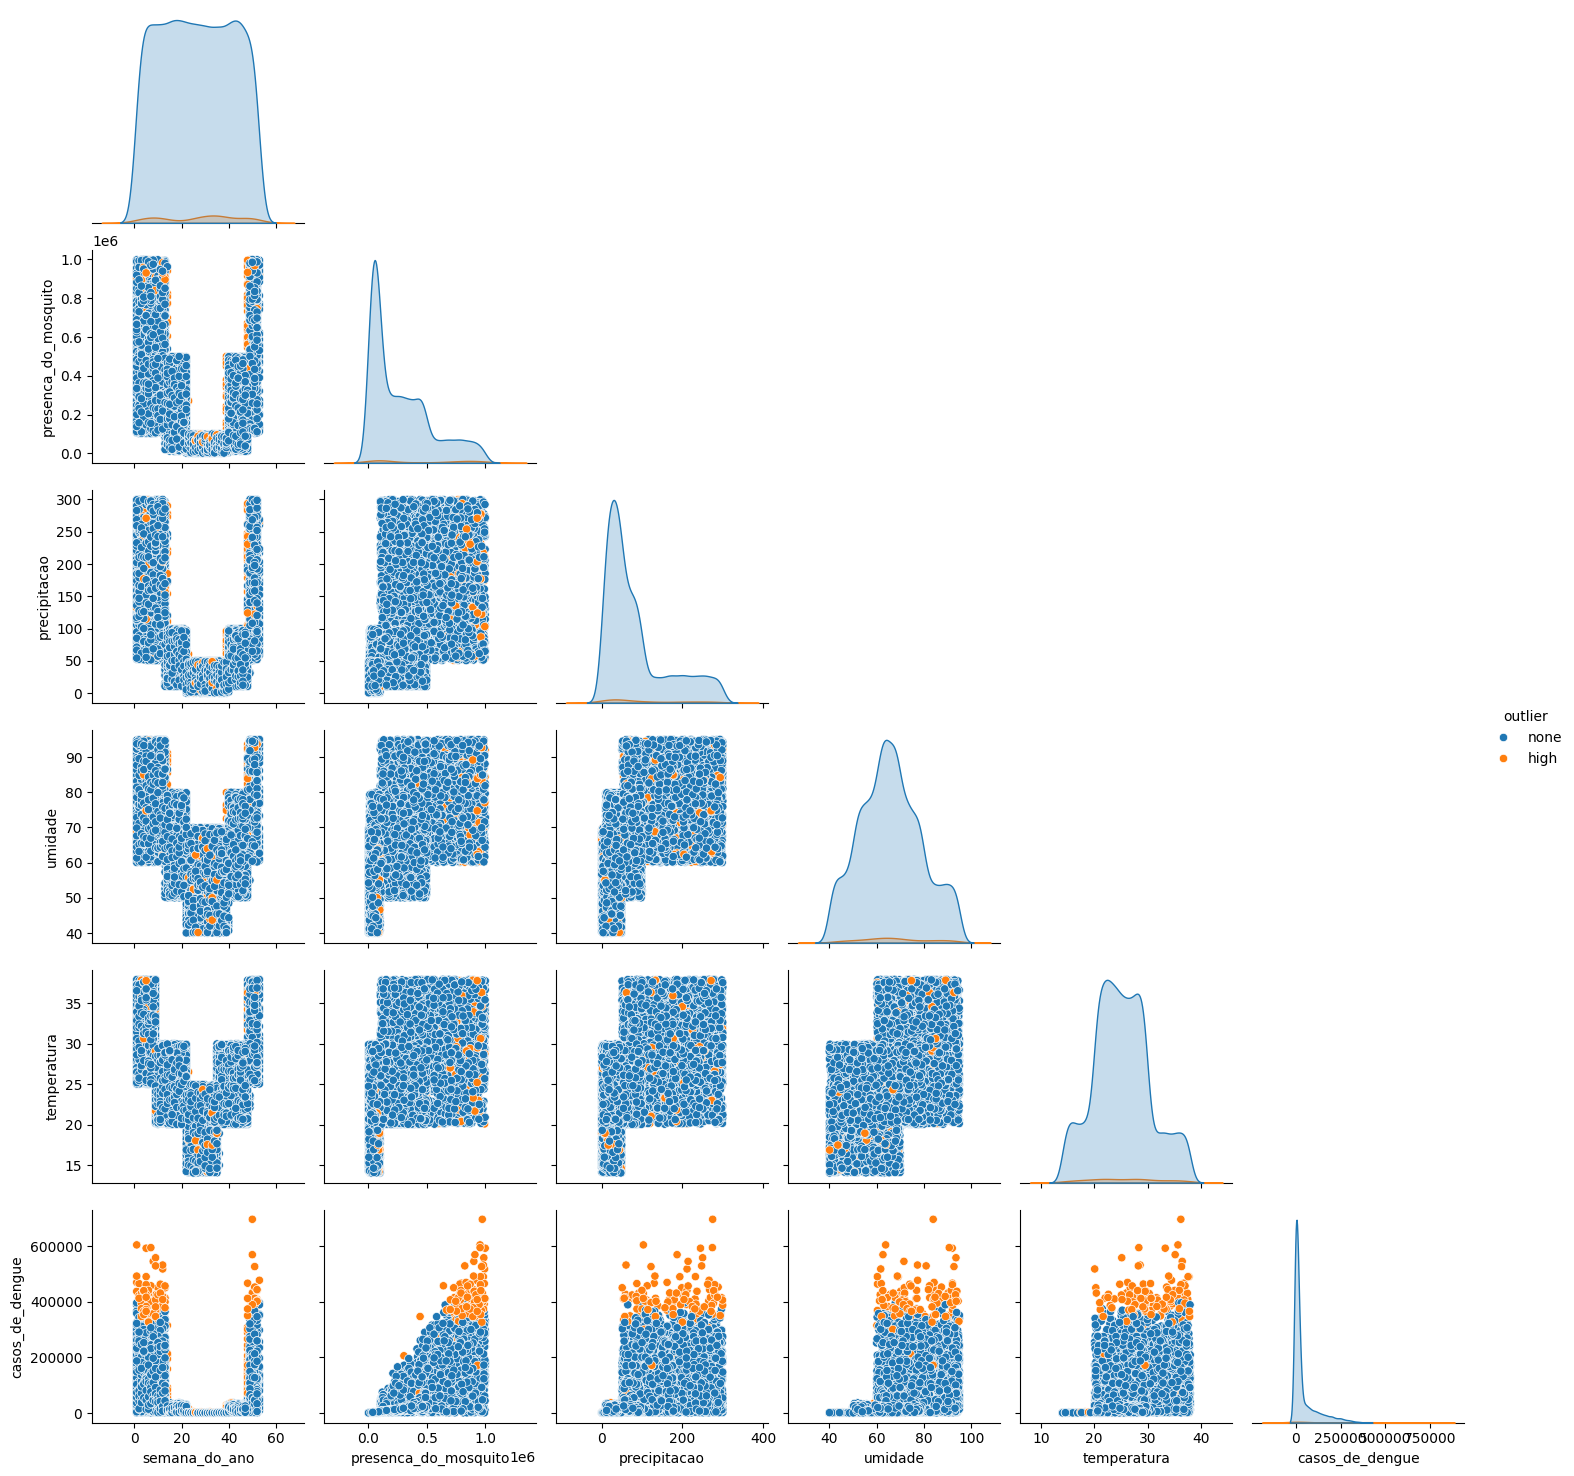

In [23]:
df3, total_outliers = outlier_identifier(df3, 'casos_de_dengue')

plt.figure(figsize=(16, 12))
sns.pairplot(df3[['semana_do_ano', 'presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura', 'outlier', 'casos_de_dengue']], hue='outlier', corner=True)
plt.show()

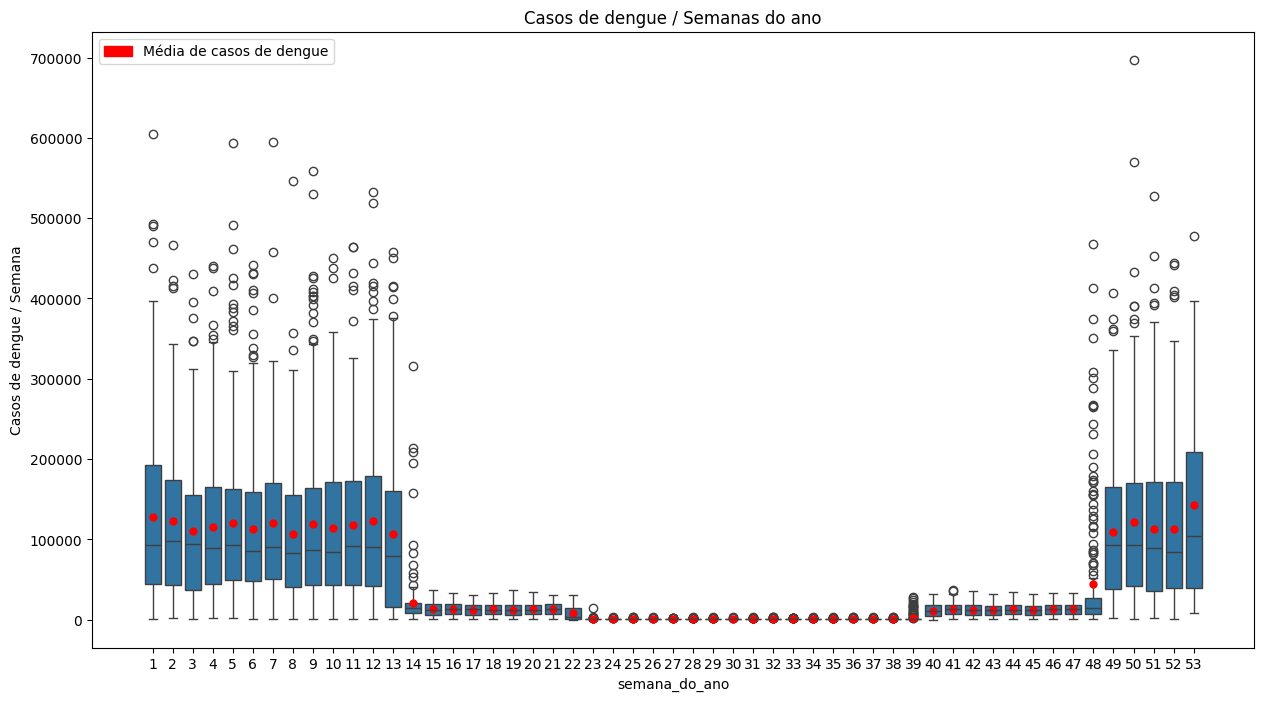

In [24]:
# Calcular a média de casos de dengue por semana do ano
mean_cases_by_week = df3.groupby('semana_do_ano')['casos_de_dengue'].mean()

# Plotar o boxplot
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df3, x='semana_do_ano', y='casos_de_dengue', ax=ax)
ax.set_title('Casos de dengue / Semanas do ano')
ax.set_ylabel('Casos de dengue / Semana')

# Adicionar a linha da média de casos de dengue por semana do ano
for week in mean_cases_by_week.index:
    ax.plot([week-1], [mean_cases_by_week[week]], marker='.', markersize=10, color='red')

# Adicionar legenda para a linha da média
import matplotlib.patches as mpatches
mean_patch = mpatches.Patch(color='red', label='Média de casos de dengue')
plt.legend(handles=[mean_patch])

plt.show()

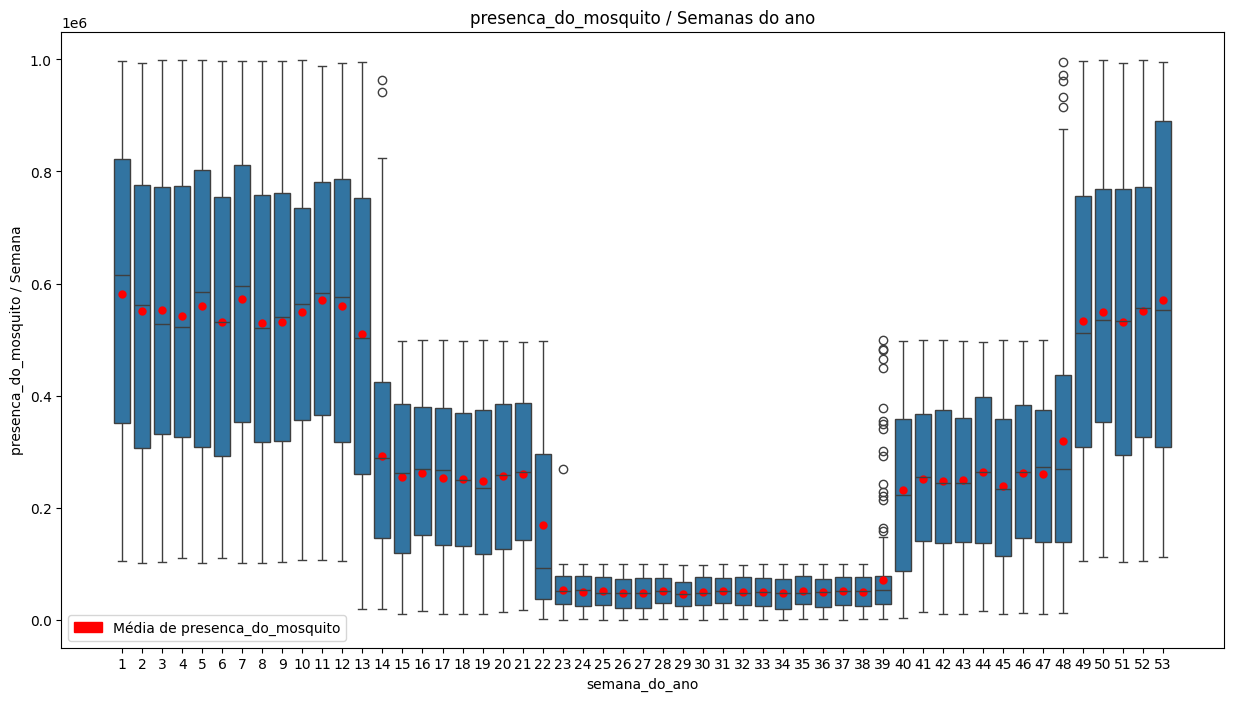

In [25]:
# Calcular a média de presenca_do_mosquito por semana do ano
mean_cases_by_week = df3.groupby('semana_do_ano')['presenca_do_mosquito'].mean()

# Plotar o boxplot
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df3, x='semana_do_ano', y='presenca_do_mosquito', ax=ax)
ax.set_title('presenca_do_mosquito / Semanas do ano')
ax.set_ylabel('presenca_do_mosquito / Semana')

# Adicionar a linha da média de presenca_do_mosquito por semana do ano
for week in mean_cases_by_week.index:
    ax.plot([week-1], [mean_cases_by_week[week]], marker='.', markersize=10, color='red')

# Adicionar legenda para a linha da média
import matplotlib.patches as mpatches
mean_patch = mpatches.Patch(color='red', label='Média de presenca_do_mosquito')
plt.legend(handles=[mean_patch])

plt.show()

Número de outliers baixos: 0
Número de outliers altos: 25


<Figure size 1600x1200 with 0 Axes>

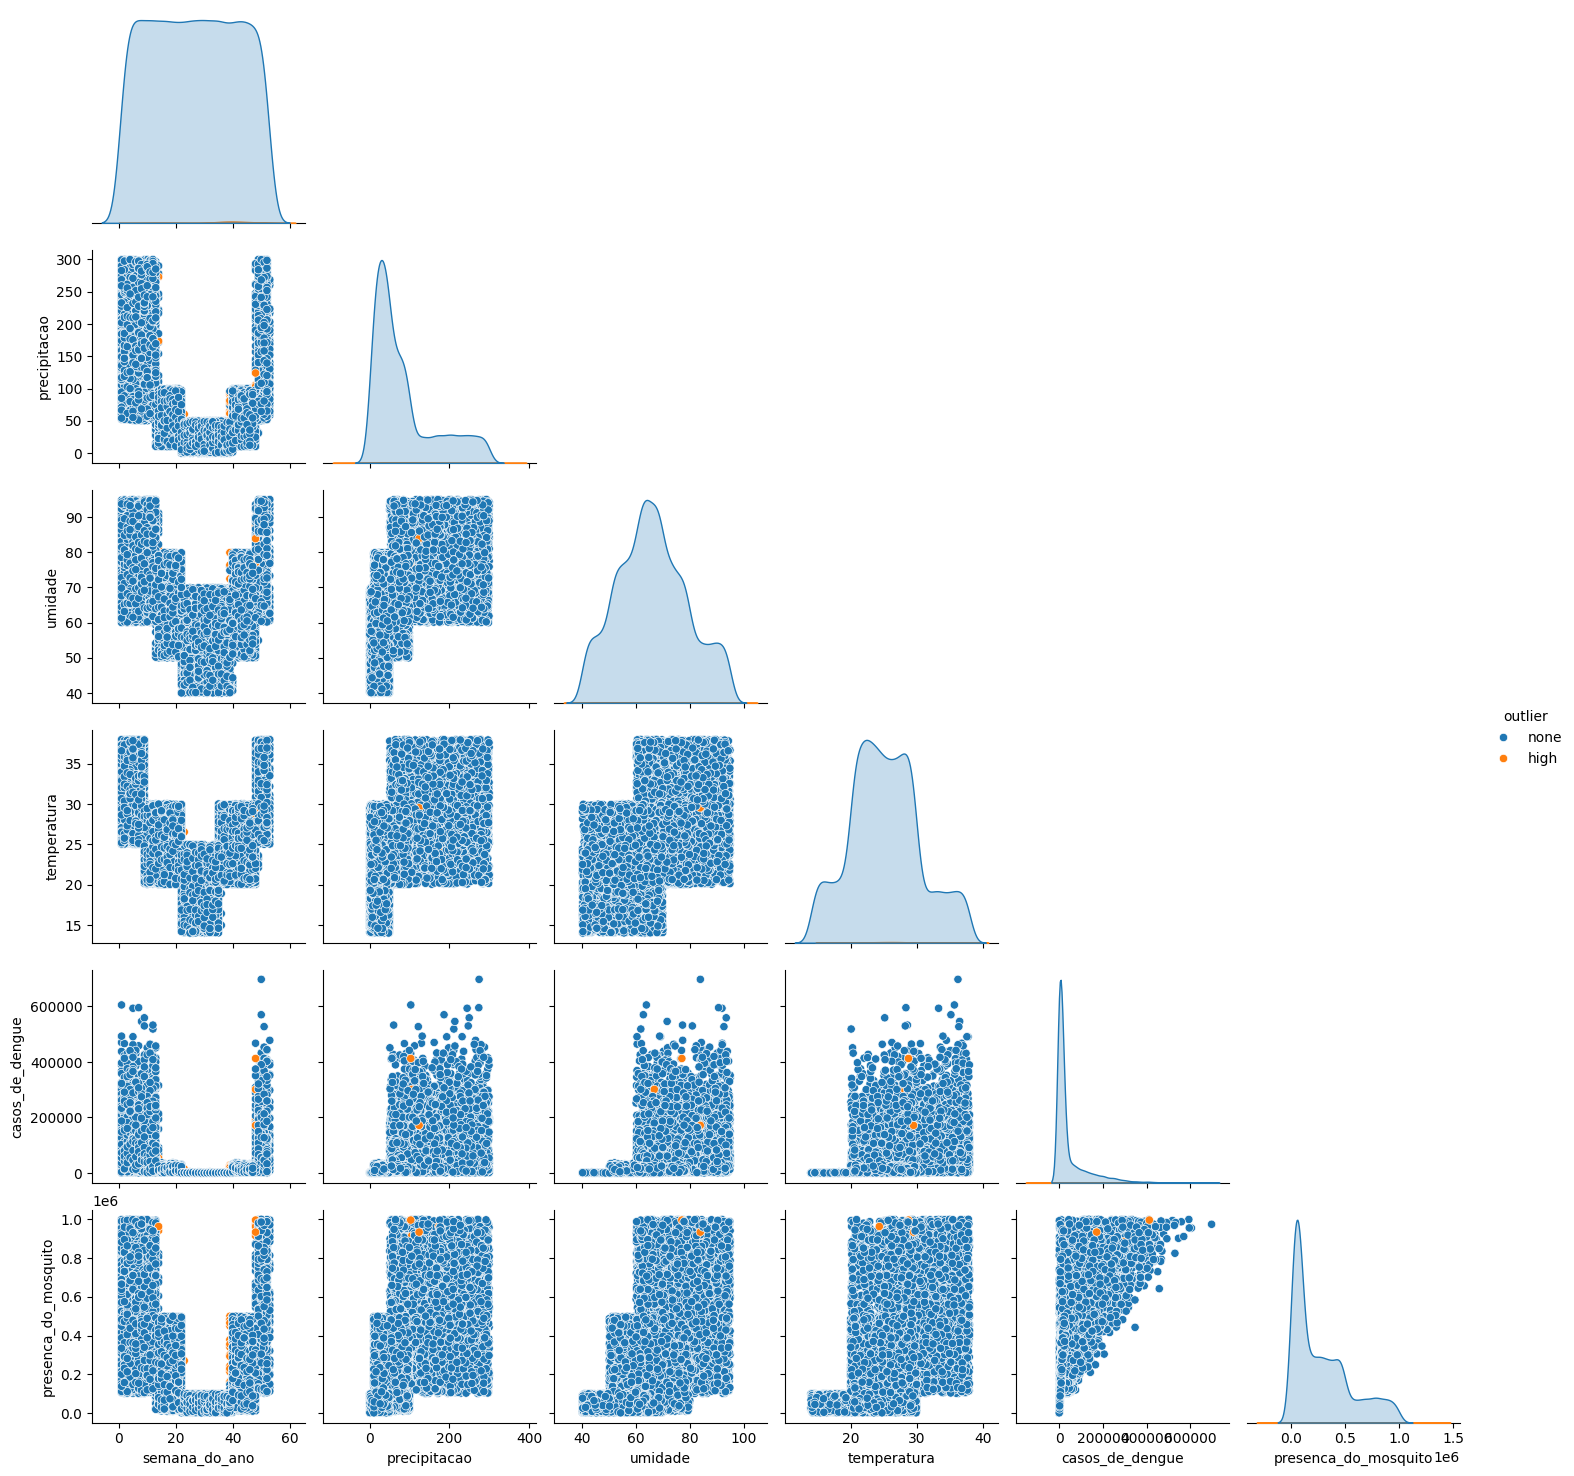

In [26]:
df3, total_outliers = outlier_identifier(df3, 'presenca_do_mosquito')
print("Número de outliers baixos:", total_outliers[0])
print("Número de outliers altos:", total_outliers[1])
df3.head()

plt.figure(figsize=(16, 12))
sns.pairplot(df3[['semana_do_ano', 'precipitacao', 'umidade', 'temperatura', 'outlier', 'casos_de_dengue', 'presenca_do_mosquito']], hue='outlier', corner=True)
plt.show()

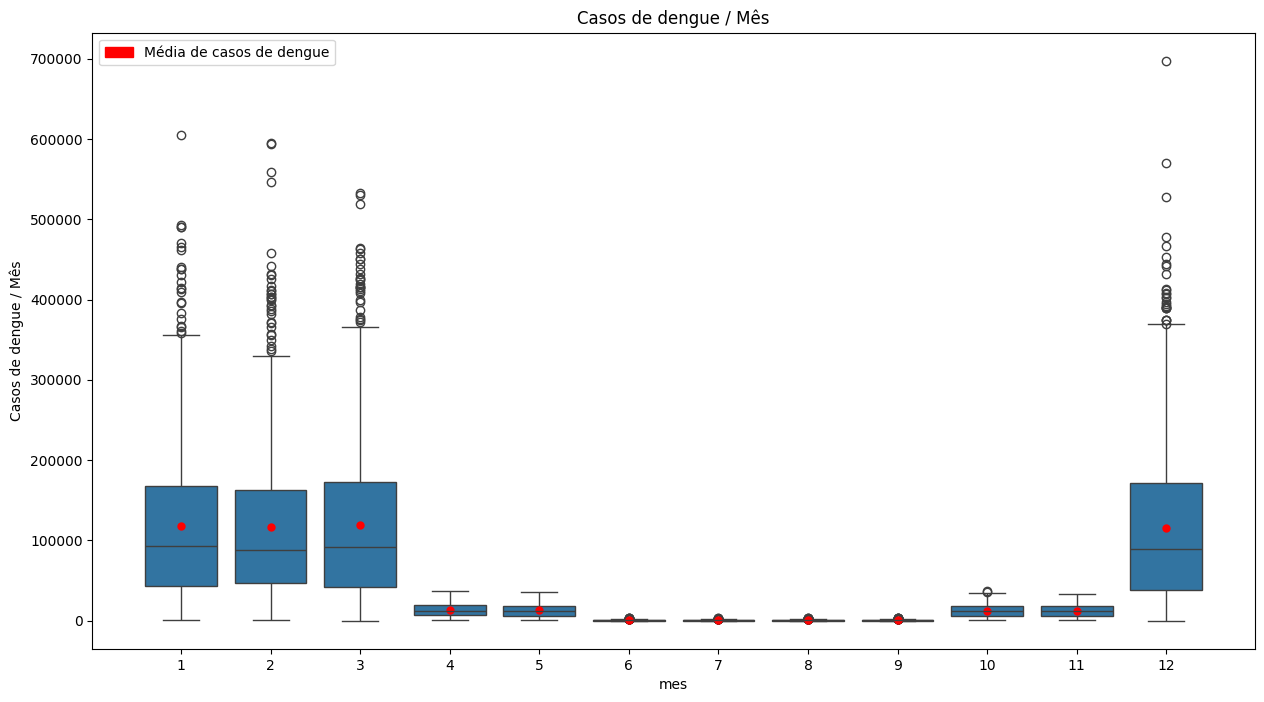

In [27]:
# Calcular a média de casos de dengue por mês
mean_cases = df3.groupby('mes')['casos_de_dengue'].mean()

# Plotar o boxplot
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df3, x='mes', y='casos_de_dengue', ax=ax)
ax.set_title('Casos de dengue / Mês')
ax.set_ylabel('Casos de dengue / Mês')

# Adicionar a linha da média de casos de dengue por mês
for month in mean_cases.index:
    ax.plot([month-1], [mean_cases[month]], marker='.', markersize=10, color='red')

# Adicionar legenda para a linha da média
import matplotlib.patches as mpatches
mean_patch = mpatches.Patch(color='red', label='Média de casos de dengue')
plt.legend(handles=[mean_patch])

plt.show()

{'precipitacao': 1110,
 'umidade': 146,
 'temperatura': 145,
 'casos_de_dengue': 2358,
 'presenca_do_mosquito': 0}

 Tô pensando em deletar todos os casos de dengue que são outliers

### 4.1.  Análise Multivariada

<Axes: >

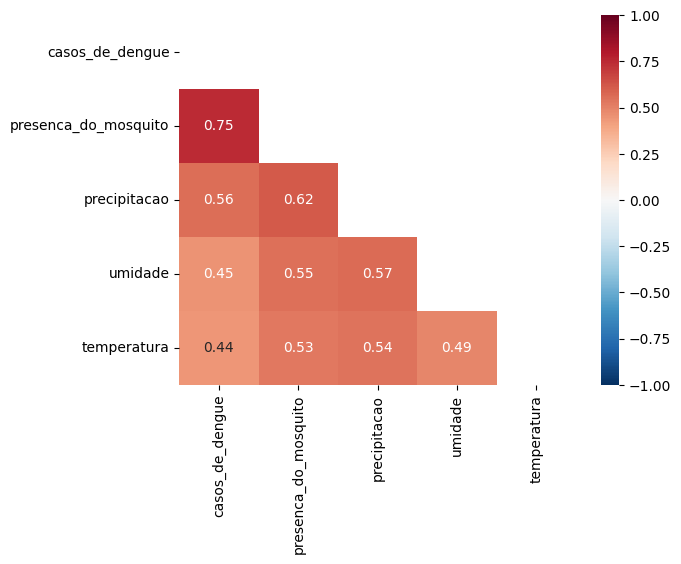

In [28]:
dfc = df3[['casos_de_dengue', 'presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura']].corr()
mask  = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dfc, annot=True, fmt='.2f', center=0, vmax=1, vmin=-1, cmap='RdBu_r', mask=mask)

<Figure size 1600x1200 with 0 Axes>

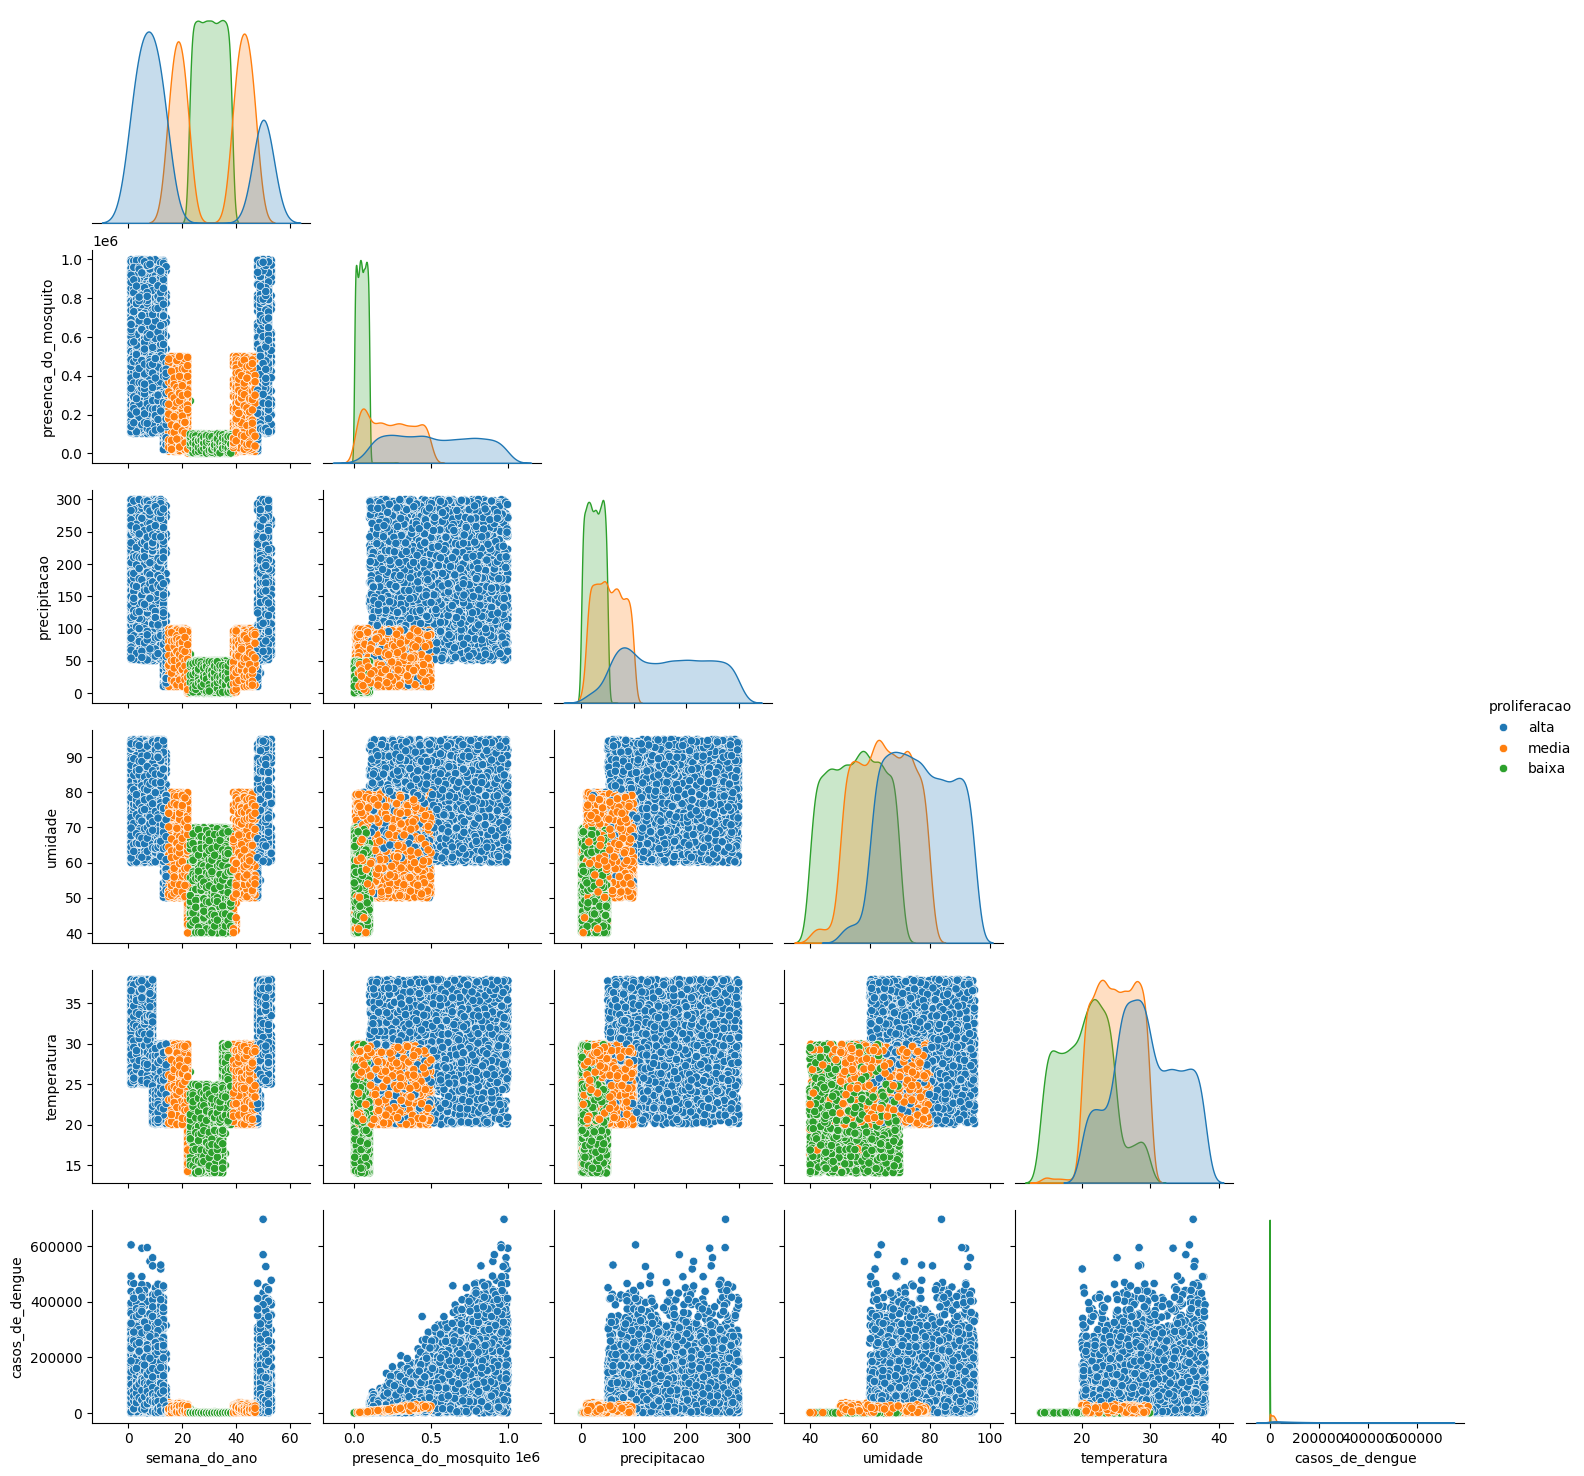

In [29]:
plt.figure(figsize=(16,12))
sns.pairplot(df3[['semana_do_ano', 'presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura', 'proliferacao', 'casos_de_dengue']], hue='proliferacao', corner=True)
plt.show()

### 4.2. Análise Bivariada

<Axes: xlabel='umidade', ylabel='casos_de_dengue'>

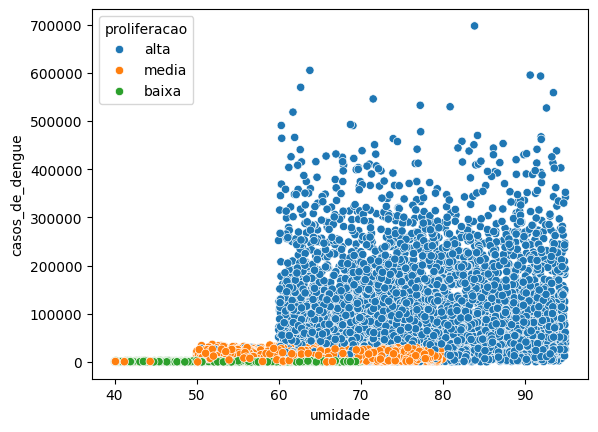

In [31]:
sns.scatterplot(x='umidade', y='casos_de_dengue', data=df3, hue='proliferacao')

### 4.3. Análise Univariada

# III. Preparação dos dados

## 5. DATA PREPARATION

**Por que é importante?**

O aprendizado dos algoritmos de ML é facilitado com dados numéricos e na mesma escala.

**O que fazer?**
- Normalização: Diminuir o grau de importância das variáveis com maior range;
- Encoding: Transformar as variáveis categóricas em numéricas;
- Rescaling: Reescala para o intervalo entre 0 e 1;
- Transformation: [Transformação cíclica do time series](https://joaquinamatrodrigo.github.io/skforecast/0.8.1/faq/cyclical-features-time-series.html) (ex.: natureza cíclica dos meses, anos, semanas etc).

### 5.1. Separar arquivos de treino e validação

In [54]:
# Calcula a data de corte para o Split Dataframe Train / Test do Time Series
days_qtd = round(df3.shape[0]*20/100)

max_date = df3['date'].max().strftime('%Y-%m-%d')

threshold_date  = df3['date'].max() - datetime.timedelta(days=days_qtd)
threshold_date = threshold_date.strftime('%Y-%m-%d')
threshold_date

print('Dataframe Max Date: {}'.format(max_date))
print('Dataframe split date (20%): {}'.format(threshold_date))

Dataframe Max Date: 2019-11-21
Dataframe split date (20%): 2013-07-29


In [55]:
NUMERICAL_FEATURES = ['presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura']
CATEGORICAL_FEATURES = ['proliferacao']
CYCLICAL_FEATURES = ['mes', 'semana_do_ano']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES + CYCLICAL_FEATURES
TARGET = 'casos_de_dengue'

SEED = 42

X = df3[FEATURES]
y = df3[TARGET]

# Split Dataframe Train / Test
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=SEED)

# Training dataset 
X_train = df3[df3['date'] < threshold_date]
y_train = X_train['casos_de_dengue']

# Validation dataset
X_val = df3[df3['date'] >= threshold_date]
y_val = X_val['casos_de_dengue']

print('Training Min Date {}'.format(X_train['date'].min()))
print('Training Max Date {}'.format(X_train['date'].max()))

print('\nTest Min Date {}'.format(X_val['date'].min()))
print('Test Max Date {}'.format(X_val['date'].max()))


Training Min Date 1987-01-01 00:00:00
Training Max Date 2013-07-28 00:00:00

Test Min Date 2013-07-29 00:00:00
Test Max Date 2019-11-21 00:00:00


### 5.3. Normalização do fenômeno

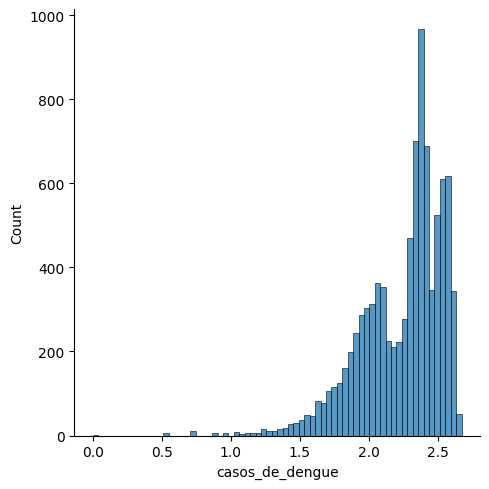

In [57]:
# Normalizar a variável dependente
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
sns.displot(y_train)

### 5.3. Demais transformações

In [58]:
# Rescalar variáveis Numéricas
numerical_transformer = MinMaxScaler()

# Encodar variáveis Categóricas
categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

# Transformar variáveis cíclicas
cyclical_transformer = ColumnTransformer(transformers=[
    ('sin_mes', sin_transformer(12), ['mes']),
    ('cos_mes', cos_transformer(12), ['mes']),
    ('sin_semana', sin_transformer(52), ['semana_do_ano']),
    ('cos_semana', cos_transformer(52), ['semana_do_ano'])
], remainder='drop')

# Pipeline
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, NUMERICAL_FEATURES),
    ('cyclical', cyclical_transformer, CYCLICAL_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES)
])

# Aplicando o pipeline ao seu conjunto de dados X_train
df_encoded = preprocessor.fit_transform(X_train)
df_encoded.head()

,num__presenca_do_mosquito,num__precipitacao,num__umidade,num__temperatura,cyclical__sin_mes__mes,cyclical__cos_mes__mes,cyclical__sin_semana__semana_do_ano,cyclical__cos_semana__semana_do_ano,cat__proliferacao_alta,cat__proliferacao_baixa,cat__proliferacao_media
0,0.874604,0.562765,0.874913,0.963421,0.5,0.866025,0.120537,0.992709,1.0,0.0,0.0
1,0.869563,0.495578,0.386017,0.650012,0.5,0.866025,0.120537,0.992709,1.0,0.0,0.0
2,0.681691,0.927274,0.680653,0.642621,0.5,0.866025,0.239316,0.970942,1.0,0.0,0.0
3,0.164831,0.653421,0.609404,0.577087,0.5,0.866025,0.239316,0.970942,1.0,0.0,0.0
4,0.362694,0.598512,0.369050,0.683468,0.5,0.866025,0.239316,0.970942,1.0,0.0,0.0


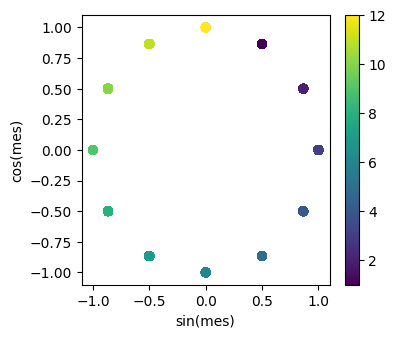

In [59]:
# Plot of the transformation
fig, ax = plt.subplots(figsize=(4., 3.5))
sp = ax.scatter(
        df_encoded["cyclical__sin_mes__mes"],
        df_encoded["cyclical__cos_mes__mes"],
        c=X_train["mes"],
        cmap='viridis'
     )
ax.set(
    xlabel="sin(mes)",
    ylabel="cos(mes)",
)
_ = fig.colorbar(sp)

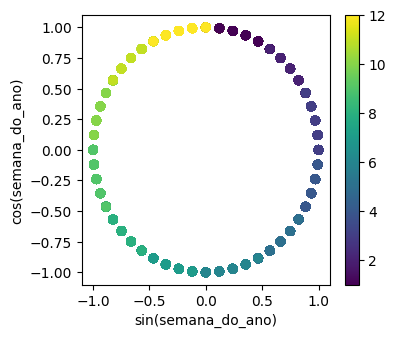

In [60]:
# Plot of the transformation
fig, ax = plt.subplots(figsize=(4., 3.5))
sp = ax.scatter(
        df_encoded["cyclical__sin_semana__semana_do_ano"],
        df_encoded["cyclical__cos_semana__semana_do_ano"],
        c=X_train["mes"],
        cmap='viridis'
     )
ax.set(
    xlabel="sin(semana_do_ano)",
    ylabel="cos(semana_do_ano)",
)
_ = fig.colorbar(sp)

# IV. Modelagem

Pipeline:
- Data cleaning
- Feature Engineering
- Transformations (Encoder dos categóricos, escala dos numéricos)

## 6. MACHINE LEARNING MODELING

In [61]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

params = {
    'model': [
        DummyRegressor(),
        LinearRegression(),
        LassoCV(random_state=SEED),
        RidgeCV(),
        RandomForestRegressor(random_state=SEED),
        GradientBoostingRegressor(random_state=SEED),
        XGBRegressor(random_state=SEED)
    ]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1)
grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [62]:
# Pegar o melhor modelo
grid_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['presenca_do_mosquito',
                                                   'precipitacao', 'umidade',
                                                   'temperatura']),
                                                 ('cyclical',
                                                  ColumnTransformer(transformers=[('sin_mes',
                                                                                   FunctionTransformer(func=<function sin_transform at 0x0000028A03E72840>,
                                                                                                       kw_args={'period': 12}),
                                                                                   ['mes']),
                                                                                  ('cos_mes',
                                                                                   FunctionTransformer(func=<functi...
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano']),
                                                                                  ('cos_semana',
                                                                                   FunctionTransformer(func=<function cos_transform at 0x0000028A03E728E0>,
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano'])]),
                                                  ['mes', 'semana_do_ano']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['proliferacao'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [63]:
# Avaliar resultados
cv_results = pd.DataFrame(grid_model.cv_results_).set_index('param_model').sort_values('rank_test_score')
cv_results.loc[:,~cv_results.columns.str.contains('split|time')].T

param_model,GradientBoostingRegressor(random_state=42),RandomForestRegressor(random_state=42),"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=42, ...)",RidgeCV(),LinearRegression(),LassoCV(random_state=42),DummyRegressor()
params,{'model': GradientBoostingRegressor(random_sta...,{'model': RandomForestRegressor(random_state=42)},"{'model': XGBRegressor(base_score=None, booste...",{'model': RidgeCV()},{'model': LinearRegression()},{'model': LassoCV(random_state=42)},{'model': DummyRegressor()}
mean_test_score,0.826341,0.818596,0.793727,0.731861,0.731858,0.731697,-0.002314
std_test_score,0.019756,0.015998,0.009937,0.022544,0.022528,0.022718,0.001723
rank_test_score,1,2,3,4,5,6,7


# V. Validação

## 7. HYPERPARAMETER FINE TUNING

### 7.1. GridSearchCV

In [64]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=SEED))
])

params = {
    'model__learning_rate': [0.1, 0.01, 1],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [250, 400, 800],
    'model__subsample': [1., .8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['presenca_do_mosquito',
                                                                          'precipitacao',
                                                                          'umidade',
                                                                          'temperatura']),
                                                                        ('cyclical',
                                                                         ColumnTransformer(transformers=[('sin_mes',
                                                                                                          FunctionTransformer(func=<function sin_transform at 0x0000028A03E72840>,
                                                                                                                              kw_args={'period': 12}),
                                                                                                          ['mes']),
                                                                                                         ('cos_mes',
                                                                                                          Func...
                                                                          'semana_do_ano']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['proliferacao'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01, 1],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [250, 400, 800],
                         'model__subsample': [1.0, 0.8]},
             scoring='r2', verbose=2)

### 7.2. Validação

In [69]:
# Avaliar resultados do melhor modelo
cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
cv_results.loc[:,~cv_results.columns.str.contains('split|time')].head(5)

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.829896,0.019235
2,0.01,4,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.829375,0.019754
3,0.01,5,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.828949,0.018060
4,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.828677,0.019570
5,0.01,5,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.828533,0.018555


In [70]:
# Pegar o melhor modelo com seus melhores parâmetros
model_pipeline = grid_model.best_estimator_
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['presenca_do_mosquito',
                                                   'precipitacao', 'umidade',
                                                   'temperatura']),
                                                 ('cyclical',
                                                  ColumnTransformer(transformers=[('sin_mes',
                                                                                   FunctionTransformer(func=<function sin_transform at 0x0000028A03E72840>,
                                                                                                       kw_args={'period': 12}),
                                                                                   ['mes']),
                                                                                  ('cos_mes',
                                                                                   FunctionTransformer(func=<functi...
                                                                                   FunctionTransformer(func=<function cos_transform at 0x0000028A03E728E0>,
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano'])]),
                                                  ['mes', 'semana_do_ano']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['proliferacao'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=4,
                                           n_estimators=400, random_state=42,
                                           subsample=0.8))])

In [71]:
# Validação dos erros
y_pred = model_pipeline.predict(X_val)
get_metrics(np.expm1(y_val), np.expm1(y_pred))

{'R2': 0.886372050202372,
 'MAE': 0.5939769069668708,
 'MAPE': 13066584362611.795,
 'RMSE': 0.8597901359459292}

<Axes: xlabel='casos_de_dengue'>

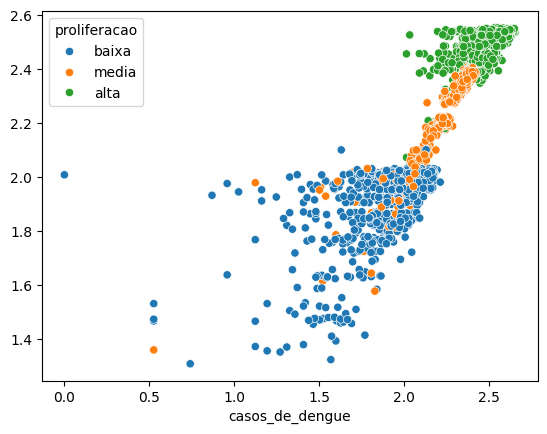

In [72]:
# Validação do gráfico
sns.scatterplot(x=y_val, y=y_pred, hue=X_val.proliferacao)

## 8. OPTIMIZATION

### 8.1. Feature Importance

- Data: Importância das features;
- Index: Nomes das features.

In [73]:
df_encoded.head()

,num__presenca_do_mosquito,num__precipitacao,num__umidade,num__temperatura,cyclical__sin_mes__mes,cyclical__cos_mes__mes,cyclical__sin_semana__semana_do_ano,cyclical__cos_semana__semana_do_ano,cat__proliferacao_alta,cat__proliferacao_baixa,cat__proliferacao_media
0,0.874604,0.562765,0.874913,0.963421,0.5,0.866025,0.120537,0.992709,1.0,0.0,0.0
1,0.869563,0.495578,0.386017,0.650012,0.5,0.866025,0.120537,0.992709,1.0,0.0,0.0
2,0.681691,0.927274,0.680653,0.642621,0.5,0.866025,0.239316,0.970942,1.0,0.0,0.0
3,0.164831,0.653421,0.609404,0.577087,0.5,0.866025,0.239316,0.970942,1.0,0.0,0.0
4,0.362694,0.598512,0.369050,0.683468,0.5,0.866025,0.239316,0.970942,1.0,0.0,0.0


<Axes: >

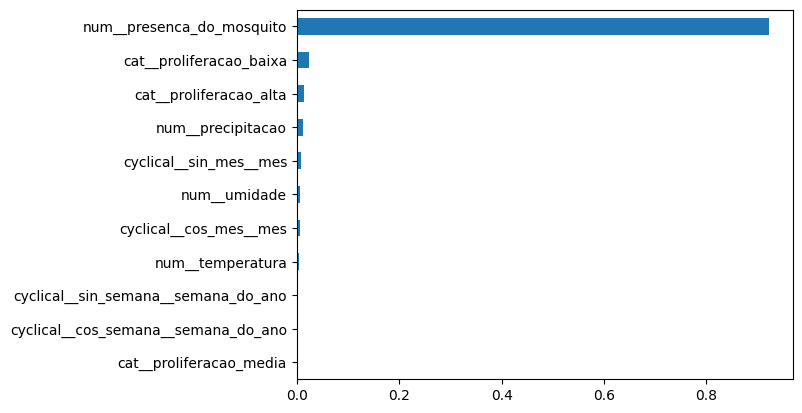

In [74]:
importances = pd.Series(
#    index = model_pipeline.named_steps['preprocessor'].get_feature_names_out(),
    index = df_encoded.columns,
    data = model_pipeline.named_steps['model'].feature_importances_
)

importances.sort_values().plot.barh()

### 8.2. Treino

### 8.3. Validação

## 9. ERROR TRANSLATION AND INTERPRETATION

### 9.1. Business Performance

### 9.2. Total Performance

# VI. Implantação

## 10. DEPLOY MODEL PRODUCTION

### 10.1. Salvar modelo

In [ ]:
# Salvar o modelo 
with open('../models/model.pkl', 'wb') as file_model:
    pickle.dump(model_pipeline, file_model)

### 10.2. Salvar arquivo de submissão

In [91]:
df_raw.columns

Index(['Date', 'conscientização da população',
       'condições de moradia precárias', 'falta de acesso a serviços de saúde',
       'migração de pessoas de áreas endêmicas',
       'transporte de mercadorias em áreas urbanas', 'outros',
       'presença do mosquito', 'Casos de dengue', 'Presença de Criadouros',
       'Água Parada em Terrenos Baldios',
       'Presença de Piscinas sem Manutenção',
       'Presença de Recipientes sem Tampas', 'Precipitação', 'Umidade',
       'Temperatura', 'Falta de Coleta de Lixo',
       'Áreas com Acúmulo de Entulhos', 'Falta de Controle de Pragas',
       'Taxa de Tratamento de Esgoto', 'id', 'status'],
      dtype='object')

In [90]:
df_teste_raw.columns

Index(['Date', 'conscientização da população',
       'condições de moradia precárias', 'falta de acesso a serviços de saúde',
       'migração de pessoas de áreas endêmicas',
       'transporte de mercadorias em áreas urbanas', 'outros',
       'presença do mosquito', 'Casos de dengue', 'Presença de Criadouros',
       'Água Parada em Terrenos Baldios',
       'Presença de Piscinas sem Manutenção',
       'Presença de Recipientes sem Tampas', 'Precipitação', 'Umidade',
       'Temperatura', 'Falta de Coleta de Lixo',
       'Áreas com Acúmulo de Entulhos', 'Falta de Controle de Pragas',
       'Taxa de Tratamento de Esgoto', 'id', 'status'],
      dtype='object')

In [98]:
# Fazer uma cópia do dataframe original
df_teste = df_teste_raw.copy()

# 0. Renomear colunas
df_teste.columns = rename_columns(df_teste.columns)

# 0. Remover duplicatas
df_teste = df_teste.drop_duplicates().reset_index(drop=True)

# Selecionar colunas
print(f'Colunas selecionadas: {selected_rows}')

# Remover a coluna alvo
df_teste = df_teste.drop('casos_de_dengue', axis=1)

# Removendo 'casos_de_dengue' da lista
selected_rows = ['casos_de_dengue', 'date'] + colunas_numericas
selected_rows.remove('casos_de_dengue')

# Limpar dataframe completo 
df_teste_cleaned, idx_nans = data_cleaning(df_teste[selected_rows], colunas_float, colunas_int)

# Porcentagem de NAN's
print("Quantidade NAN's nas colunas selecionadas: {:.2} %".format((len(idx_nans) * 100)/df_teste_cleaned.shape[0]))

# Imprimir descrição dos dados antes da limpeza
print('*' *9 + ' Descrição dos dados | ANTES da limpeza ' + '*' *7)
data_description(df_teste_cleaned)

# Deletar linhas com NAN's
df_teste_cleaned_without_nans = df_teste_cleaned.drop(idx_nans, axis=0).reset_index(drop=True)

# Verificar se a quantidade de linhas deletadas está de acordo
df_teste_cleaned.shape[0] - len(idx_nans) == df_teste_cleaned_without_nans.shape[0]

# Imprimir descrição dos dados depois da limpeza
print('*' *9 + ' Descrição dos dados | DEPOIS da limpeza ' + '*' *7)
data_description(df_teste_cleaned_without_nans)

df_teste3 = df_teste_cleaned_without_nans.copy()

df_teste3 = feature_engineering(df_teste3)

X_test = df_teste3.copy()


Colunas selecionadas: ['date', 'precipitacao', 'umidade', 'temperatura', 'presenca_do_mosquito']
Quantidade NAN's nas colunas selecionadas: 4.1 %
********* Descrição dos dados | ANTES da limpeza *******
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 1,500
Quantidade de colunas: 7

******************** DATA TYPES *************************
date                    datetime64[ns]
precipitacao                   float64
umidade                        float64
temperatura                    float64
presenca_do_mosquito             int64
mes                              int32
semana_do_ano                   UInt32
dtype: object

******************** CHECK NAs **************************
date                    0
precipitacao            0
umidade                 0
temperatura             0
presenca_do_mosquito    0
mes                     0
semana_do_ano           0
dtype: int64

******************** CHECK DUPLICATED *******************
Quantidade de registros dup

,num__presenca_do_mosquito,num__precipitacao,num__umidade,num__temperatura,cyclical__sin_mes__mes,cyclical__cos_mes__mes,cyclical__sin_semana__semana_do_ano,cyclical__cos_semana__semana_do_ano,cat__proliferacao_alta,cat__proliferacao_baixa,cat__proliferacao_media
0,0.084246,0.009062,0.537553,0.564074,-1.0,-1.836970e-16,-0.935016,-0.354605,0.0,1.0,0.0
1,0.060544,0.065424,0.512110,0.472651,-0.5,8.660254e-01,-0.568065,0.822984,0.0,0.0,1.0
2,0.069278,0.101540,0.380781,0.492980,-0.5,8.660254e-01,-0.568065,0.822984,0.0,0.0,1.0
3,0.454559,0.174618,0.716074,0.560163,-0.5,8.660254e-01,-0.464723,0.885456,1.0,0.0,0.0
4,0.136835,0.085432,0.673340,0.630755,-0.5,8.660254e-01,-0.464723,0.885456,1.0,0.0,0.0


In [109]:
# Aplicando o pipeline ao seu conjunto de dados X_test
df_teste_encoded = preprocessor.fit_transform(X_test)
df_teste_encoded.head()

,num__presenca_do_mosquito,num__precipitacao,num__umidade,num__temperatura,cyclical__sin_mes__mes,cyclical__cos_mes__mes,cyclical__sin_semana__semana_do_ano,cyclical__cos_semana__semana_do_ano,cat__proliferacao_alta,cat__proliferacao_baixa,cat__proliferacao_media
0,0.084246,0.009062,0.537553,0.564074,-1.0,-1.836970e-16,-0.935016,-0.354605,0.0,1.0,0.0
1,0.060544,0.065424,0.512110,0.472651,-0.5,8.660254e-01,-0.568065,0.822984,0.0,0.0,1.0
2,0.069278,0.101540,0.380781,0.492980,-0.5,8.660254e-01,-0.568065,0.822984,0.0,0.0,1.0
3,0.454559,0.174618,0.716074,0.560163,-0.5,8.660254e-01,-0.464723,0.885456,1.0,0.0,0.0
4,0.136835,0.085432,0.673340,0.630755,-0.5,8.660254e-01,-0.464723,0.885456,1.0,0.0,0.0


In [110]:
df_teste_encoded.shape

(1438, 11)

In [115]:
y_hat_test = model_pipeline.predict(X_test)
final_test = pd.concat([df_teste_encoded, pd.Series(np.expm1(y_hat_test), name='Casos de dengue')], axis=1)
final_test = final_test[['date', 'Casos de dengue']].sort_values('date')
final_test.shape
final_test

KeyError: "['date'] not in index"

In [ ]:
# Exportar o arquivo
final_test.to_csv('datasets/submission_xgb_XX.csv', index=False)

### 10.3. Prever resultados do teste